<a href="https://colab.research.google.com/github/bardagan/logo_classifier/blob/master/flickr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

### Connect to Google **Drive**

In [62]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Getting and converting the data

In [0]:
path = '/content/drive/My Drive/data/flickr_logos_27_dataset'

In [32]:
path_images = path + "/flickr_logos_27_dataset_images"
path_images

'/content/drive/My Drive/data/flickr_logos_27_dataset/flickr_logos_27_dataset_images'

In [33]:
cal = np.genfromtxt(path +'/flickr_logos_27_dataset_training_set_annotation.txt', dtype='str'); cal

array([['144503924.jpg', 'Adidas', '1', '38', '12', '234', '142'],
       ['2451569770.jpg', 'Adidas', '1', '242', '208', '413', '331'],
       ['390321909.jpg', 'Adidas', '1', '13', '5', '89', '60'],
       ['4761260517.jpg', 'Adidas', '1', '43', '122', '358', '354'],
       ...,
       ['217288720.jpg', 'Yahoo', '6', '136', '161', '304', '222'],
       ['2472817996.jpg', 'Yahoo', '6', '2', '4', '499', '106'],
       ['2514220918.jpg', 'Yahoo', '6', '1', '69', '342', '157'],
       ['386891249.jpg', 'Yahoo', '6', '156', '10', '310', '49']], dtype='<U14')

In [0]:
data_points = {}
for point in cal:
  data_points[point[0]] = np.genfromtxt(point[2:])
data_points

In [0]:
#delete images that don't have data points:
files = os.listdir(path_images)

for file in files:
  if file not in cal:
    print(path_images + "/" + file)
    os.remove(path_images + "/" + file)

In [0]:
fname = '1690276845.jpg' #example

In [0]:
# def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

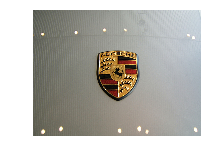

In [38]:
img = open_image(path_images + '/' + fname)
img.show()

In [0]:
# ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

In [0]:
def get_middle(f):
    if isinstance(f, Path):
      f = f.name 
    ctr = data_points[f]
    return tensor((ctr[4] + ctr[2])/2, (ctr[3]+ctr[1])/2)
def get_frame(f):
    ctr = data_points[f]
    # return tensor(ctr[2],ctr[1])
    return tensor(ctr[4], ctr[3])

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [41]:
get_middle(fname)

tensor([192., 252.])

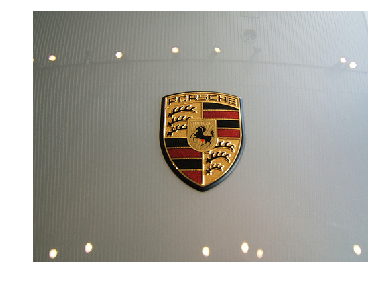

In [42]:
ctr = get_middle(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [0]:
np.random.seed(42)

In [0]:
def rand_valid_func(x):
  return np.random.random() < 0.2

In [45]:
rand_valid_func(5)

False

In [0]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_warp = 0.0, max_rotate=0.0, max_zoom=1.0)
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(rand_valid_func)
        .label_from_func(get_middle)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

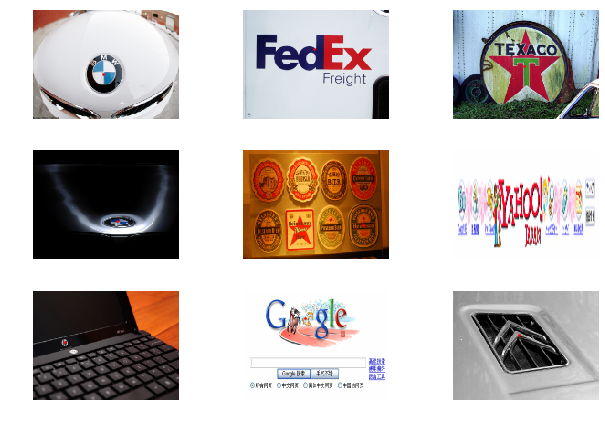

In [47]:
data.show_batch(3, figsize=(9,6))

## Train model

In [0]:
learn = cnn_learner(data, models.resnet34)

In [0]:
# learn.lr_find()
# learn.recorder.plot()

In [0]:
lr = 5e-2

In [51]:
learn.fit_one_cycle(15, slice(lr))

epoch,train_loss,valid_loss,time
0,3.943366,4.920228,01:32
1,3.488086,1.752910,00:12
2,2.618320,1.858547,00:09
3,2.214583,0.887374,00:09
4,1.875782,0.747441,00:09
5,1.567839,0.215559,00:09
6,1.293049,0.137748,00:09
7,1.065666,0.138999,00:09
8,0.880252,0.103577,00:09
9,0.732732,0.111783,00:09


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

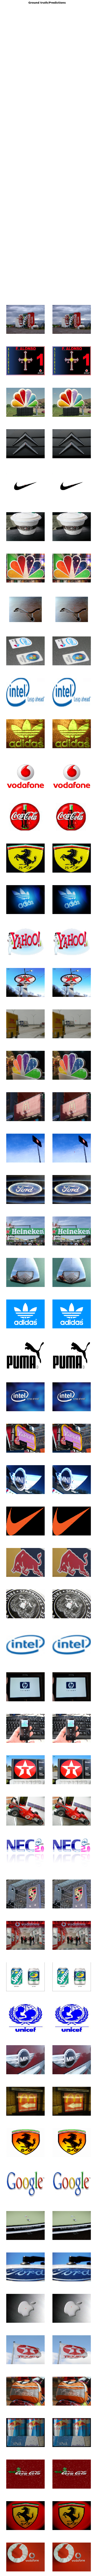

In [64]:
learn.show_results(rows=55)

## Data augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

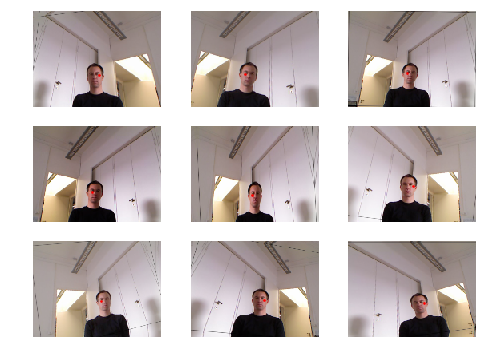

In [0]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))